In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import random

from IPython import display
from skimage.draw import random_shapes, rectangle, polygon, circle

from attention_augmented_conv import augmented_conv2d

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
SHAPE_SIZE = 128
CHANNELS = 1
IMAGE_COUNT = 300
NUM_CLASSES = 1 + 1 # BG + Classes
MAX_SHAPES = 3
BATCH_SIZE = 8
EPOCHS = 150
NUM_EXAMPLES_TO_GENERATE = 8

In [3]:
def generate_image_mask(size=(448, 448), max_shapes=3, show_result=False):
    masks = []
    while(len(masks) == 0):
        image, labels = random_shapes(size, min_shapes=1, max_shapes=max_shapes,
                                 min_size=size[0]/4, allow_overlap=False, multichannel=(CHANNELS == 3),
                                     num_trials = 10)#, shape='triangle'

        # Generate individual masks    
        for i in range(0, len(labels)):
            img= np.zeros(size, dtype=np.uint8)
            class_id = 0

            if(labels[i][0] == 'rectangle'):
                continue
                #rr, cc = rectangle((labels[i][1][0][0], labels[i][1][1][0]), (labels[i][1][0][1], labels[i][1][1][1]),
                #           shape=img.shape)
                #class_id = 1
            if(labels[i][0] == 'circle'):
                continue
                #y = labels[i][1][0][1]- (labels[i][1][0][1] - labels[i][1][0][0]) / 2
                #x = labels[i][1][1][1]-(labels[i][1][1][1] - labels[i][1][1][0]) / 2
                #r = (labels[i][1][0][1] - labels[i][1][0][0]) / 2        
                #rr, cc = circle(y, x, r, shape=img.shape)
                #class_id = -1
            if(labels[i][0] == 'triangle'):
                x = (labels[i][1][1][0], labels[i][1][1][1] - (labels[i][1][1][1] - labels[i][1][1][0]) / 2, labels[i][1][1][1], labels[i][1][1][0])
                y = (labels[i][1][0][1], labels[i][1][0][0], labels[i][1][0][1], labels[i][1][0][1])
                rr, cc = polygon(y, x, shape=img.shape)  
                class_id = 1

            img[rr, cc] = class_id
            masks.append(img)

        if(len(masks) == 0):
            continue
        # Merge the masks
        mask = np.zeros(size, dtype=np.uint8)
        for i in range(0, len(masks)):
            mask = np.add(mask, masks[i])

        background = 1 - mask
        final_mask = np.dstack((background, mask))

        if(show_result):
            print(labels)
            fig=plt.figure(figsize=(8, 8))
            fig.add_subplot(1, len(labels)+1, 1)
            plt.imshow(image)
            for i in range(0, len(labels)):    
                fig.add_subplot(1, len(labels)+1, i+2)
                plt.imshow(masks[i], cmap="Greys")
            plt.show()
        return image, final_mask

In [4]:
def preprocess_image(raw_image):
    t = tf.convert_to_tensor(raw_image, np.float32)
    #print(t.shape)
    if(CHANNELS == 1):
        t = tf.reshape(t, (SHAPE_SIZE, SHAPE_SIZE, CHANNELS,))
    #t = (t - 127.5) / 127.5
    #else: t = t / 255.0
    t = t / 255.0
    return t

def preprocess_mask(raw_mask):
    t = tf.convert_to_tensor(raw_mask, np.float32)
    t = tf.reshape(t, (SHAPE_SIZE, SHAPE_SIZE, NUM_CLASSES,))
    return t

/usr/local/lib/python3.6/dist-packages/skimage/draw/_random_shapes.py:349: UserWarning: Could not fit any shapes to image, consider reducing the minimum dimension
  warn('Could not fit any shapes to image, '


0
30
60
90
120
150
180
210
240
270
(128, 128, 1)


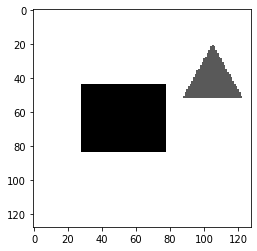

In [5]:
images = []
masks = []
for i in range(0, IMAGE_COUNT):
    image, img_mask = generate_image_mask(size=(SHAPE_SIZE, SHAPE_SIZE), max_shapes=MAX_SHAPES)
    images.append(preprocess_image(image))
    masks.append(preprocess_mask(img_mask))
    #masks.append(img_mask)
    if((i / IMAGE_COUNT * 100.0) % 10 == 0):
        print(i)
# Display a sample image
print(images[0].shape)
if(CHANNELS == 1):
    plt.imshow(images[0][:, :, 0], cmap='gray')
else : plt.imshow(images[0])
#print(masks[0][:,:, 0])
#print(masks[0][:,:, 1])

In [6]:
img_ds = tf.data.Dataset.from_tensor_slices(images)
msk_ds = tf.data.Dataset.from_tensor_slices(masks)
img_msk_ds = tf.data.Dataset.zip((img_ds, msk_ds))

In [7]:
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
#ds = img_msk_ds.apply(
#  tf.data.experimental.shuffle_and_repeat(buffer_size=IMAGE_COUNT))
#ds = ds.batch(BATCH_SIZE)
#ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#ds

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = img_msk_ds.shuffle(buffer_size=IMAGE_COUNT)
#ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 2)), types: (tf.float32, tf.float32)>

In [8]:
def make_segmentation_model(conv_size):
    c = 32
    model = tf.keras.Sequential()
    max_depth = SHAPE_SIZE // c
    print('Max depth:{}'.format(max_depth))
    # DOWN    
    for i in range(1, max_depth+1):
        print(i)
        cc = int(c * (i * 2))
        model.add(layers.Conv2D(cc, conv_size, strides=(1, 1), padding='same', use_bias=False, input_shape=(SHAPE_SIZE,SHAPE_SIZE,CHANNELS)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.MaxPool2D())
        
        # Making sure we don't end up into negative dimensions
        if(model.output_shape[1] == 1):
            print('True depth:{}'.format(i))
            break
            
    
    
    # UP    
    for i in range(max_depth+1, 1, -1):
        cc = int(c * (i * 2))
        model.add(layers.Conv2DTranspose(cc, (3, 3), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        
        if(model.output_shape[1] == SHAPE_SIZE):
            break

    model.add(layers.Conv2D(NUM_CLASSES, (1, 1), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.Softmax())

    return model

Max depth:4
1
2
3
4
Max depth:4
1
2
3
4
(1, 128, 128, 2)


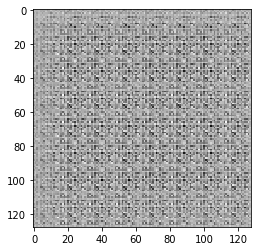

In [22]:
segmentator1 = make_segmentation_model((2, 2))
#tf.keras.Sequential(
#    [
#        tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(SHAPE_SIZE, SHAPE_SIZE, CHANNELS)),
        #tf.keras.layers.AveragePooling2D(),
        #tf.keras.layers.Dense(NUM_CLASSES),
        #tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), strides=(1, 1), padding='same', use_bias=False),
        #tf.keras.layers.Softmax()
#    ]
#)#make_segmentation_model((2, 2))
segmentator2 = make_segmentation_model((3, 3))

noise = tf.random.normal([1, SHAPE_SIZE, SHAPE_SIZE, CHANNELS])
image_mask = segmentator1(noise, training=False)
print(image_mask.shape)

if(CHANNELS == 1):
    plt.imshow(image_mask[0, :, :, 0], cmap='gray')
else: plt.imshow(image_mask[0, :, :, 0])

(1, 128, 128, 2)


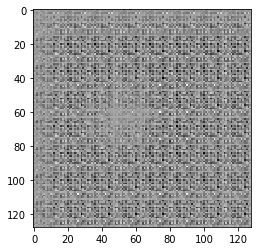

In [23]:
image_mask2 = segmentator1(tf.reshape(tf.convert_to_tensor(images[0]), (1, SHAPE_SIZE, SHAPE_SIZE, CHANNELS)), training=False)
print(image_mask2.shape)
if(CHANNELS == 1):
    plt.imshow(image_mask2[0, :, :, 0], cmap='gray')
else: plt.imshow(image_mask2[0, :, :, 0])
#segmentator1.summary()

In [24]:
def make_meta_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[SHAPE_SIZE, SHAPE_SIZE, NUM_CLASSES * 2]))
    
    #model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    #model.add(layers.AveragePooling2D())
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    
    
    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())   
    
    model.add(layers.Conv2D(NUM_CLASSES, (1, 1), strides=(1, 1), padding='same', use_bias=False))
    #model.add(layers.Softmax())
    model.add(layers.ReLU())
    
    return model

In [25]:
metanet = make_meta_model()
timage = tf.reshape(tf.convert_to_tensor(images[0]), (1, SHAPE_SIZE, SHAPE_SIZE, CHANNELS))
tfinal = tf.concat([image_mask, image_mask], -1)
#print(tfinal.shape)
decision = metanet(tfinal)
print (decision.shape)

(1, 128, 128, 2)


In [26]:
#This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def metanet_loss(truth, real_output, seg_output):
    #real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    #seg_loss = cross_entropy(tf.zeros_like(seg_output), seg_output)
    real_loss = cce(truth, real_output)
    seg_loss = cce(truth, seg_output)
    total_loss = real_loss + seg_loss
    return total_loss

def segmentator_loss(truth, seg_output):
    #return cross_entropy(tf.ones_like(seg_output), seg_output)
    return cce(truth, seg_output)

In [27]:
segmentation_optimizer = tf.keras.optimizers.Adam(1e-4)
meta_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
checkpoint_dir = './prototype_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(segmentation_optimizer=segmentation_optimizer,
                                 meta_optimizer=meta_optimizer,
                                 segmentator1=segmentator1,
                                 metanet=metanet)

In [29]:
noise_dim = SHAPE_SIZE
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
#seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, noise_dim, noise_dim, 1])
seed = []
seed_truth = []
for i in range(0, NUM_EXAMPLES_TO_GENERATE):
    img, truth = generate_image_mask(size=(SHAPE_SIZE, SHAPE_SIZE), max_shapes=MAX_SHAPES)
    seed.append(preprocess_image(img))
    seed_truth.append(preprocess_mask(truth))
seed = tf.convert_to_tensor(seed)

/usr/local/lib/python3.6/dist-packages/skimage/draw/_random_shapes.py:349: UserWarning: Could not fit any shapes to image, consider reducing the minimum dimension
  warn('Could not fit any shapes to image, '


In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, masks):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim, noise_dim, 1])

    with tf.GradientTape() as seg_tape1, tf.GradientTape() as seg_tape2, tf.GradientTape() as meta_tape:#
        generated_masks1 = segmentator1(images, training=True)
        generated_masks2 = segmentator2(images, training=True)

        #real_output = metanet(tf.concat([masks, masks], -1), training=True)
        seg_output = metanet(tf.concat([generated_masks1, generated_masks2], -1), training=True)

        seg_loss1 = segmentator_loss(seg_output, generated_masks1)
        seg_loss2 = segmentator_loss(seg_output, generated_masks2)
        meta_loss = segmentator_loss(masks, seg_output)

    gradients_of_segmentator1 = seg_tape1.gradient(seg_loss1, segmentator1.trainable_variables)
    gradients_of_segmentator2 = seg_tape2.gradient(seg_loss2, segmentator2.trainable_variables)
    gradients_of_metanet = meta_tape.gradient(meta_loss, metanet.trainable_variables)

    segmentation_optimizer.apply_gradients(zip(gradients_of_segmentator1, segmentator1.trainable_variables))
    segmentation_optimizer.apply_gradients(zip(gradients_of_segmentator2, segmentator2.trainable_variables))
    meta_optimizer.apply_gradients(zip(gradients_of_metanet, metanet.trainable_variables))
    return seg_loss1, seg_loss2#, meta_loss

In [35]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, mask_batch in dataset:
            seg_loss1, seg_loss2 = train_step(image_batch, mask_batch)#, meta_loss

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(segmentator1, segmentator2,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('Segmentation loss is {}, {}'.format(seg_loss1, seg_loss2))
        #print('Meta loss is {}'.format(meta_loss))
        #print(metanet.output_loss)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(segmentator1, segmentator2,
                           epochs,
                           seed)

In [36]:
def generate_and_save_images(model1, model2, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions1 = model1(test_input, training=False)
    predictions2 = model2(test_input, training=False)

    fig = plt.figure(figsize=(NUM_EXAMPLES_TO_GENERATE,NUM_EXAMPLES_TO_GENERATE))
    offset = 1
    for i in range(predictions1.shape[0]):
        plt.subplot(NUM_EXAMPLES_TO_GENERATE, 4, i+offset)
        plt.imshow(predictions1[i, :, :, 1], cmap='gray')
        plt.axis('off')
        offset = offset + 1
        plt.subplot(NUM_EXAMPLES_TO_GENERATE, 4, i+offset)
        plt.imshow(predictions2[i, :, :, 1], cmap='gray')
        plt.axis('off')
        offset = offset + 1
        plt.subplot(NUM_EXAMPLES_TO_GENERATE, 4, i+offset)
        plt.imshow(seed_truth[i][:, :, 1], cmap='gray')
        plt.axis('off')
        offset = offset + 1
        plt.subplot(NUM_EXAMPLES_TO_GENERATE, 4, i+offset)
        if(CHANNELS == 1):
            plt.imshow(seed[i][:, :, 0], cmap='gray')
        else: plt.imshow(seed[i])
        plt.axis('off')

    plt.savefig('prototype_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

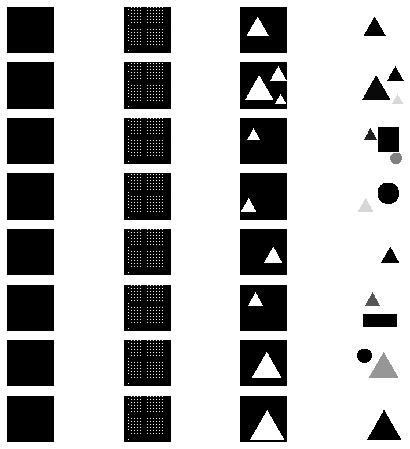

Time for epoch 37 is 8.311954736709595 sec
Segmentation loss is 0.7774263620376587, 0.874972939491272


In [ ]:
%%time
train(ds, EPOCHS)

In [ ]:
anim_file = 'prototype.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('prototype_image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        #frame = 2*(i**0.5)
        #if round(frame) > round(last):
        #  last = frame
        #else:«
        #  continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
#if IPython.version_info > (6,2,0,''):
display.Image(filename=anim_file)